In [71]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel
import numpy as np

In [48]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibm_lagos'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

ibmqfactory.load_account:WARNING:2021-11-07 16:23:08,564: Credentials are already in use. The existing account in the session will be replaced.


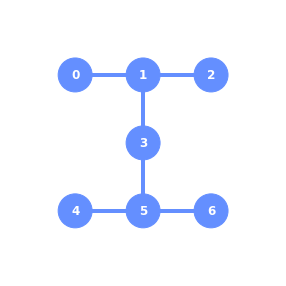

In [49]:
qubits = plot_gate_map(backend)
qubits

# Let's take a look at the CX schedule and the cross-resonance gate within

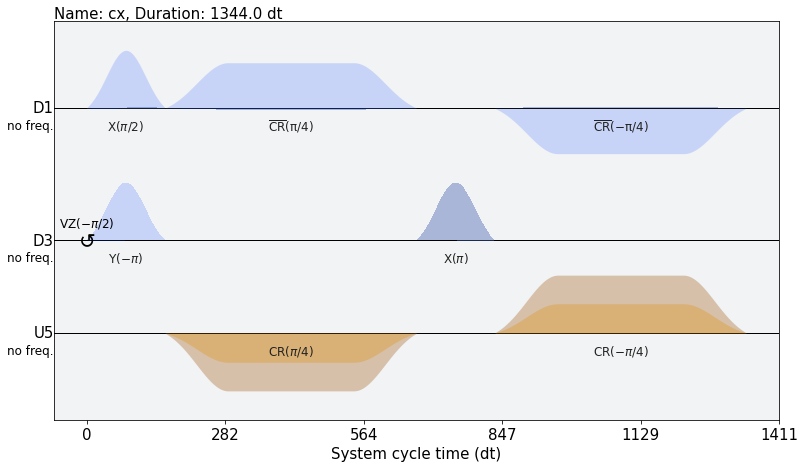

In [93]:
q1, q2 = 3, 1
# q1, q2 = 3, 5
cx_sched = inst_map.get('cx', qubits=[q1, q2])
cx_sched.draw()

In [94]:
for inst in cx_sched.instructions:
    print(inst)

(0, ShiftPhase(1.5707963267948966, DriveChannel(3)))
(0, ShiftPhase(1.5707963267948966, ControlChannel(3)))
(0, ShiftPhase(1.5707963267948966, ControlChannel(8)))
(0, Play(Drag(duration=160, amp=(0.0969041209298364+0.0008960652620970415j), sigma=40, beta=-1.4266716117122862, name='X90p_d1'), DriveChannel(1), name='X90p_d1'))
(0, Play(Drag(duration=160, amp=(-3.997261812604306e-17-0.21760079806342836j), sigma=40, beta=-0.8656847299894538, name='Ym_d3'), DriveChannel(3), name='Ym_d3'))
(160, Play(GaussianSquare(duration=512, amp=(0.07615786679450226-0.002401546028469394j), sigma=64, width=256, name='CR90p_d1_u5'), DriveChannel(1), name='CR90p_d1_u5'))
(160, Play(GaussianSquare(duration=512, amp=(-0.22263257576950227-0.44012884381827344j), sigma=64, width=256, name='CR90p_u5'), ControlChannel(5), name='CR90p_u5'))
(672, Play(Drag(duration=160, amp=(0.21760079806342836+0j), sigma=40, beta=-0.8656847299894538, name='Xp_d3'), DriveChannel(3), name='Xp_d3'))
(832, Play(GaussianSquare(duration

In [100]:
def build_cr_schedule(backend, qc, qt, cr_params):
    
    with pulse.build(backend=backend, default_alignment="left", name="cr_schedule") as cross_resonance:
        pulse.play(GaussianSquare(
            duration=cr_params["duration"],
            amp=cr_params["cr_amp"],
            width=cr_params["width"],
            sigma=cr_params["sigma"],
        ),
        pulse.control_channels(qc, qt)[0],
    )
        if not np.isclose(cr_params["cancel_amp"], 0.0):
            pulse.play(GaussianSquare(
                duration=cr_params["duration"],
                amp=cr_params["cancel_amp"],
                width=cr_params["width"],
                sigma=cr_params["sigma"],
        ),
        pulse.drive_channel(qt),
    )
        else:
            pulse.delay(cr_params["duration"], pulse.drive_channel(qt))
        pulse.delay(cr_params["duration"], pulse.drive_channel(qc))
        
    return cross_resonance

def build_cr_circuit(gate):
    
    cr_circuit = QuantumCircuit(2)
    cr_circuit.append(gate, [0, 1])
    cr_circuit.x(0)
    cr_circuit.rz(np.pi, 1)
    cr_circuit.append(gate, [0, 1])
    cr_circuit.rz(-np.pi, 1)
    
    return cr_circuit

def build_experiment_circuits(backend, qc, qt, amps, cr_params):
    
    circ_list = []
    for amplitude in amps:
        cr_gate = circuit.Gate(
            "cr_gate",
            num_qubits=2,
            params=[amplitude],
        )

        exp_circ = QuantumCircuit(2, 1)

        ## add control state prep when needed

        exp_circ.compose(other=build_cr_circuit(cr_gate), qubits=[0, 1], inplace=True)

        exp_circ.metadata={
            "qubits": [qc, qt]
        }
        cr_params['cr_amp'] = amplitude
        exp_circ.add_calibration(gate=cr_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params))
        
        
        circ_list.append(exp_circ)
    return circ_list

In [101]:
cr_params = {}
cr_params['duration'] = 528
cr_params["width"] = 272
cr_params["sigma"] = 64
cr_params["cr_amp"] = 0.0
cr_params["cancel_amp"] = 0.0

max_cr_amplitude = 0.25
cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, 20)
exp_circuits = build_experiment_circuits(backend, q1, q2, cr_amps, cr_params)
print(len(exp_circuits))
exp_circuits[4].draw()

20


┌────────────────────┐  ┌───┐  ┌────────────────────┐          
q_0: ┤0                   ├──┤ X ├──┤0                   ├──────────
     │  cr_gate(-0.14474) │┌─┴───┴─┐│  cr_gate(-0.14474) │┌────────┐
q_1: ┤1                   ├┤ Rz(π) ├┤1                   ├┤ Rz(-π) ├
     └────────────────────┘└───────┘└────────────────────┘└────────┘
c: 1/═══════════════════════════════════════════════════════════════

In [105]:
tc = transpile(exp_circuits[4], backend, initial_layout=[q1, q2])
sched = schedule(exp_circuits[4], backend)
for inst in sched.instructions:
    print(inst)

QiskitError: "Operation 'cr_gate' on qubit(s) [0, 1] not supported by the backend command definition. Did you remember to transpile your input circuit for the same backend?"